<a href="https://colab.research.google.com/github/fathanzys/Data/blob/Machine-Learning/uas_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Import**

####**1.1 Import Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**1.2 Import Library**

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

#**2. Data Collection**

####**2.1 Load Dataset**

In [27]:
df = pd.read_csv('/content/drive/MyDrive/DM/loan_data.csv')

####**2.2 Informasi Data**

In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB
None


In [30]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


#**3. EDA**

####**3.1 Missing Values**

In [31]:
print(df.isnull().sum())

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64


####**3.2 Visualisasi distribusi Label**

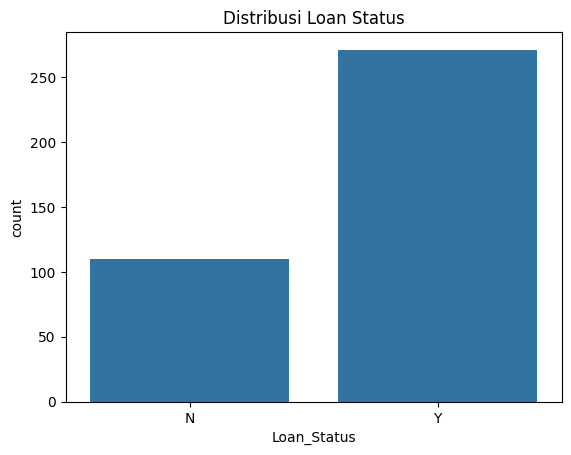

In [32]:
sns.countplot(x='Loan_Status', data=df)
plt.title("Distribusi Loan Status")
plt.show()

####**3.3 Korelasi Fitur**

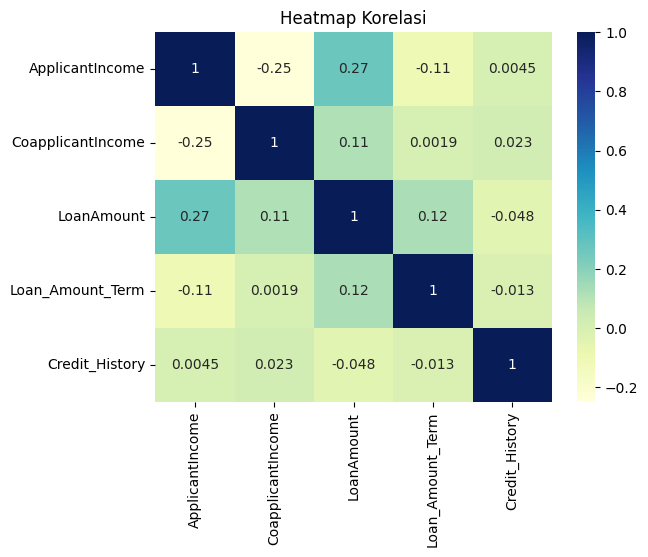

In [33]:
numerics = ['int64', 'float64']
df_num = df.select_dtypes(include=numerics)
sns.heatmap(df_num.corr(), annot=True, cmap='YlGnBu')
plt.title("Heatmap Korelasi")
plt.show()

#**4. Pre-Processing**

####**4.1 Isi Missing Value**

In [34]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

####**4.2 Drop Kolom**

In [35]:
df.drop(columns=['Loan_ID'], inplace=True)

####**4.3 Encode Kategorikal**

In [36]:
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

#**5. Train-Test Split**

In [37]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#**6. Model Evaluation**

####**6.1 Logistic Regression**

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.50      0.65        22
           1       0.83      0.98      0.90        55

    accuracy                           0.84        77
   macro avg       0.87      0.74      0.77        77
weighted avg       0.86      0.84      0.83        77



####**6.2 Decision Tree**

In [39]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred_tree = dtree.predict(X_test)

print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        22
           1       0.86      0.93      0.89        55

    accuracy                           0.84        77
   macro avg       0.82      0.78      0.80        77
weighted avg       0.84      0.84      0.84        77



####**6.3 Random Forest**

In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        22
           1       0.86      0.98      0.92        55

    accuracy                           0.87        77
   macro avg       0.89      0.79      0.82        77
weighted avg       0.88      0.87      0.86        77



#**7. Confussion Matrix**

In [42]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

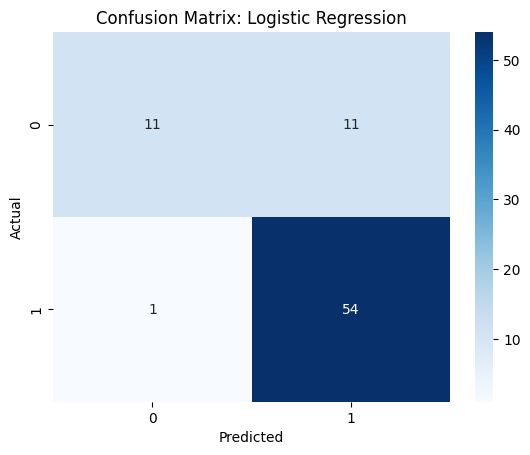

In [43]:
plot_conf_matrix(y_test, y_pred_log, "Confusion Matrix: Logistic Regression")

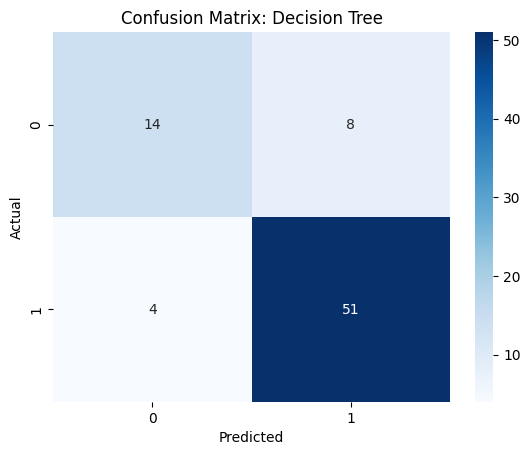

In [44]:
plot_conf_matrix(y_test, y_pred_tree, "Confusion Matrix: Decision Tree")

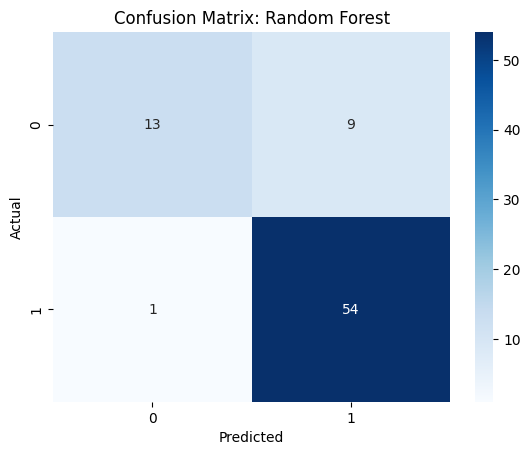

In [45]:
plot_conf_matrix(y_test, y_pred_rf, "Confusion Matrix: Random Forest")

#**8. Comparison**

In [46]:
print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred_log))
print("Accuracy Decision Tree:", accuracy_score(y_test, y_pred_tree))
print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))

Accuracy Logistic Regression: 0.8441558441558441
Accuracy Decision Tree: 0.8441558441558441
Accuracy Random Forest: 0.8701298701298701
